In [1]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip

--2025-02-18 14:52:37--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/content/cassavaleafdata.zip’

/content/cassavalea 100%[===================>]   1.26G  37.5MB/s    in 37s     

2025-02-18 14:53:15 (34.5 MB/s) - ‘/content/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [2]:
!unzip /content/cassavaleafdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  infla

In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib . pyplot as plt
from PIL import Image

#Data

##Preprocess data

In [4]:
data_paths = {
    'train': './cassavaleafdata/train',
    'val': './cassavaleafdata/validation',
    'test': './cassavaleafdata/test'
}

In [5]:
def loader(path):
  return Image.open(path)

In [6]:
img_size = 150
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    data_paths['train'],
    transform=train_transform,
    loader=loader
)

valid_data = datasets.ImageFolder(
    data_paths['val'],
    transform=train_transform,
)

test_data = datasets.ImageFolder(
    data_paths['test'],
    transform=train_transform,
)

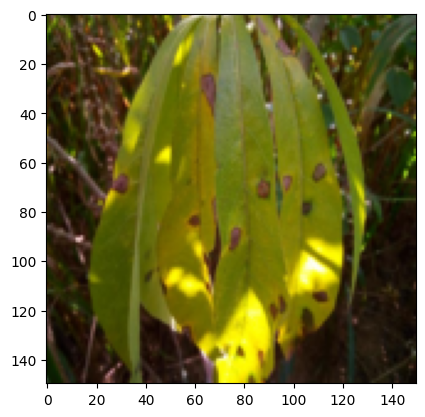

In [7]:
plt.imshow(train_data[0][0].permute(1, 2, 0))


##Data loader

In [8]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

#Modeling

##Model

In [9]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(
        in_channels=3,
        out_channels=6,
        kernel_size=5,
        padding='same'
    )
    self.avgpool1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(
        in_channels=6,
        out_channels=16,
        kernel_size=5
    )
    self.avgpool2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(16 * 35 * 35, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    outputs = self.conv1(x)
    outputs = self.avgpool1(outputs)
    outputs = F.relu(outputs)
    outputs = self.conv2(outputs)
    outputs = self.avgpool2(outputs)
    outputs = F.relu(outputs)
    outputs = self.flatten(outputs)
    outputs = self.fc1(outputs)
    outputs = self.fc2(outputs)
    outputs = self.fc3(outputs)
    return outputs

##Train function

In [10]:
def train(model, optimizer, criterion, dataloader, device, epoch = 0, log_interval = 50):
  model.train()
  total_acc, total_count = 0, 0
  losses = []

  for idx, (inputs, labels) in enumerate(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    #compute loss
    loss = criterion(outputs, labels)
    losses.append(loss.item())
    #backward
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    total_acc += (outputs.argmax(1) == labels).sum().item()
    total_count += labels.size(0)

    if (idx + 1) % log_interval == 0:
      print(
          '| epoch {:3d} | {:5d}/{:5d} batches '
          '| accuracy {:8.3f} | loss {:8.3f} | '.format(
              epoch, idx + 1, len(dataloader),
              total_acc / total_count, np.mean(losses)
          )
      )
      total_acc, total_count = 0, 0

  epoch_acc = total_acc / total_count
  epoch_loss = np.mean(losses)
  return epoch_acc, epoch_loss

##Evaluate function

In [11]:
def evaluate(model, criterion, dataloader, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      total_acc += (outputs.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = np.mean(losses)
  return epoch_acc, epoch_loss

##Training

In [14]:
num_classes = len(train_data.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model = LeNetClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
lr = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), lr=lr)

num_epochs = 20
save_model = './model'
if (not os.path.exists(save_model)):
  os.makedirs(save_model)

train_accs, train_losses = [], []
valid_accs, valid_losses = [], []
best_loss_val = 100

for epoch in range(1, num_epochs+1):
  train_acc, train_loss = train(
      lenet_model, optimizer, criterion, train_dataloader, device, epoch
  )
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  valid_acc, valid_loss = evaluate(
      lenet_model, criterion, valid_dataloader, device
  )
  valid_accs.append(valid_acc)
  valid_losses.append(valid_loss)

  #Save best model
  if valid_loss < best_loss_val:
    best_loss_val = valid_loss
    torch.save(lenet_model.state_dict(), save_model + '/best_model.pt')

  #Print loss, acc, epoch
  print('-'*60)
  print(
      '| end of epoch {:3d} | train accuracy {:8.3f} | train loss {:8.3f} | '
      'valid accuracy {:8.3f} | valid loss {:8.3f} | '.format(
          epoch, train_acc, train_loss, valid_acc, valid_loss
      )
  )
  print('-'*60)


------------------------------------------------------------
| end of epoch   1 | train accuracy    0.450 | train loss    1.423 | valid accuracy    0.470 | valid loss    1.365 | 
------------------------------------------------------------
------------------------------------------------------------
| end of epoch   2 | train accuracy    0.470 | train loss    1.337 | valid accuracy    0.470 | valid loss    1.333 | 
------------------------------------------------------------
------------------------------------------------------------
| end of epoch   3 | train accuracy    0.470 | train loss    1.339 | valid accuracy    0.471 | valid loss    1.332 | 
------------------------------------------------------------
------------------------------------------------------------
| end of epoch   4 | train accuracy    0.472 | train loss    1.304 | valid accuracy    0.478 | valid loss    1.300 | 
------------------------------------------------------------
----------------------------------------

##Visualize

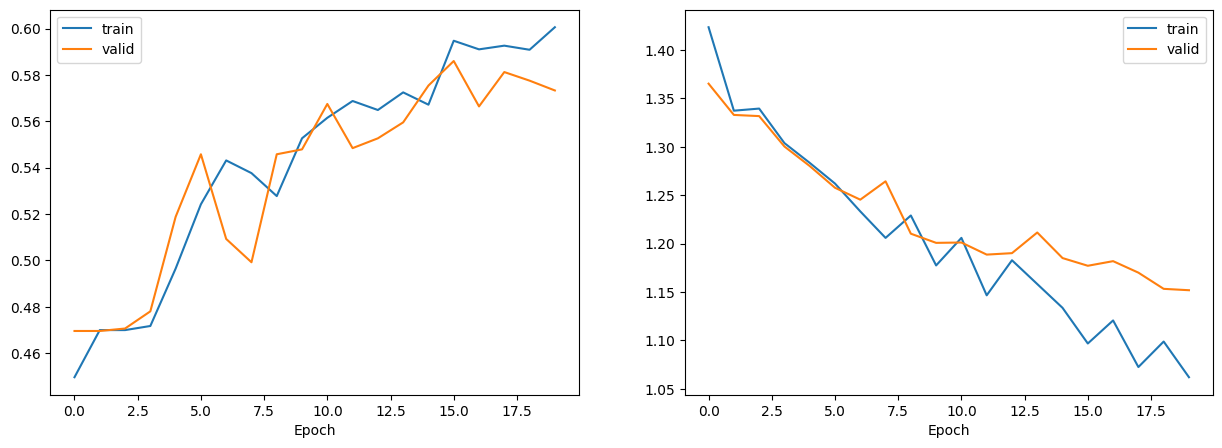

In [15]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(train_accs, label = 'train')
ax[0].plot(valid_accs, label = 'valid')

ax[1].plot(train_losses, label = 'train')
ax[1].plot(valid_losses, label = 'valid')

for i in range(2):
  ax[i].set_xlabel('Epoch')
  ax[i].legend()

##Evaluating

In [16]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.5787798408488064, 1.1304659843444824)

##Download

In [18]:
from google.colab import files

files.download(save_model + '/best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>